In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

### Lens Parameters
units: um

In [3]:
def grid(m, n):
    # Grid of numbers in the range of -1~1
    # shape = (2, m, n)
    xi = tf.range(0, m, dtype=tf.dtypes.float32)/(m-1)-0.5
    yi = tf.range(0, n, dtype=tf.dtypes.float32)/(n-1)-0.5
    xx, yy = tf.meshgrid(xi, yi) 
    return tf.concat([xx[tf.newaxis], yy[tf.newaxis]], 0) * 2

In [4]:
# Dimensions
lens_radius = 12
sensor_radius = 4
N1 = 71 # sampled points on lens
N2 = 71 # sampled points on sensor

# create coordinates
p1 = grid(N1, N1) * lens_radius
p1 = tf.concat([p1, tf.zeros([1, N1, N1])], 0)
p2 = grid(N2, N2) * sensor_radius

In [5]:
def lens(p1, k, focal_length):
    lens_mask = k * tf.sqrt(focal_length**2 + tf.reduce_sum(p1**2, 0))
    return lens_mask

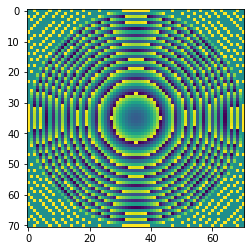

In [6]:
wavelengths = np.array([0.630, 0.532, 0.465]) # R, G, B
k = 2*np.pi/wavelengths
focal_length = 10
lens_phase = lens(p1, k[1], focal_length)
lens_phase = tf.cast(lens_phase, tf.dtypes.complex64)
circle_mask = tf.reduce_sum(p1**2, 0)<lens_radius**2
circle_mask = tf.cast(circle_mask, tf.dtypes.complex64)
lens_mask = tf.exp(1j*lens_phase) * circle_mask
plt.imshow(tf.math.angle(lens_mask))

In [7]:
def Huygens(p1, p2, k, mask):
    p2_shape = p2.shape
    p1 = tf.reshape(p1, [3, -1, 1]) # xyz, "lens", sensor
    p2 = tf.reshape(p2, [3, 1, -1]) # xyz, lens, "sensor"

    dd = p2-p1
    d2 = tf.reduce_sum(dd**2, 0)
    d = tf.sqrt(d2)

    mask = tf.reshape(mask, [1, -1, 1])
    mask = tf.cast(mask, tf.dtypes.complex64)

    k = tf.cast(k, tf.dtypes.complex64)
    d = tf.cast(d, tf.dtypes.complex64)
    dd = tf.cast(dd, tf.dtypes.complex64)
    d2 = tf.cast(d2, tf.dtypes.complex64)

    phase = mask * tf.exp(-1j * k * d)
    I = tf.reduce_mean(phase * dd[2] / d2, 1)
    I = tf.reshape(I, p2_shape[1:])
    
    return I

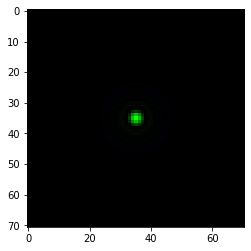

In [47]:

sensor_distance = 10


def createPSF(sensor_distance, lens_mask, angle=0.0):
    sensor_p2 = tf.concat([p2, tf.ones([1, N2, N2])*sensor_distance], 0)
    sensor_p2 = sensor_p2 + [[[tf.tan(angle)*sensor_distance]], [[0]], [[0]]]

    offsetR = tf.exp(-1j*tf.cast(p1[0] * tf.sin(angle) * k[0], tf.dtypes.complex64))
    offsetG = tf.exp(-1j*tf.cast(p1[0] * tf.sin(angle) * k[0], tf.dtypes.complex64))
    offsetB = tf.exp(-1j*tf.cast(p1[0] * tf.sin(angle) * k[0], tf.dtypes.complex64))
    IR = Huygens(p1, sensor_p2, k[0], lens_mask * offsetR)
    IG = Huygens(p1, sensor_p2, k[1], lens_mask * offsetG)
    IB = Huygens(p1, sensor_p2, k[2], lens_mask * offsetB)
    I = tf.concat([[IR], [IG], [IB]], 0)
    I = tf.abs(I)**2
    I = tf.cast(I/tf.reduce_sum(I), tf.dtypes.complex64)

    return I


I = createPSF(sensor_distance, lens_mask, 0.0)
plt.imshow(tf.abs(tf.transpose(I, [1, 2, 0]))/tf.reduce_max(tf.abs(I)))
plt.show()


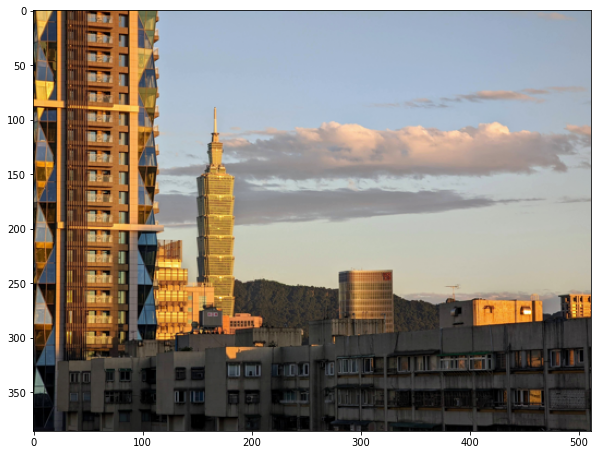

In [48]:
img = Image.open('./hans_test/Taipei101.jpg')
width = 512
img = img.resize([width, round(img.height/img.width*width)])
img = np.array(img)/255
plt.figure(figsize=(10,10))
plt.imshow(img)
img = np.pad(img, [[I.shape[1], I.shape[1]], [I.shape[2], I.shape[2]], [0, 0]])


In [49]:


def padding(I, img):
    I_shape = np.array(I.shape[1:]).astype("int")
    img_shape = np.array(np.shape(img)[:-1]).astype("int")
    pad_shape = img_shape-I_shape
    middle = np.floor((I_shape+1)/2.0).astype("int")
    I_pad = tf.concat([
        I[:, middle[0]:],
        tf.zeros([3, pad_shape[0], I_shape[1]], tf.dtypes.complex64),
        I[:, :middle[0]]
    ], 1)

    I_pad = tf.concat([
        I_pad[:, :, middle[0]:],
        tf.zeros([3, img_shape[0], pad_shape[1]], tf.dtypes.complex64),
        I_pad[:, :, :middle[0]]
    ], 2)
    return I_pad

I_pad = padding(I, img)
# plt.imshow(tf.abs(I_pad[1])**0.2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


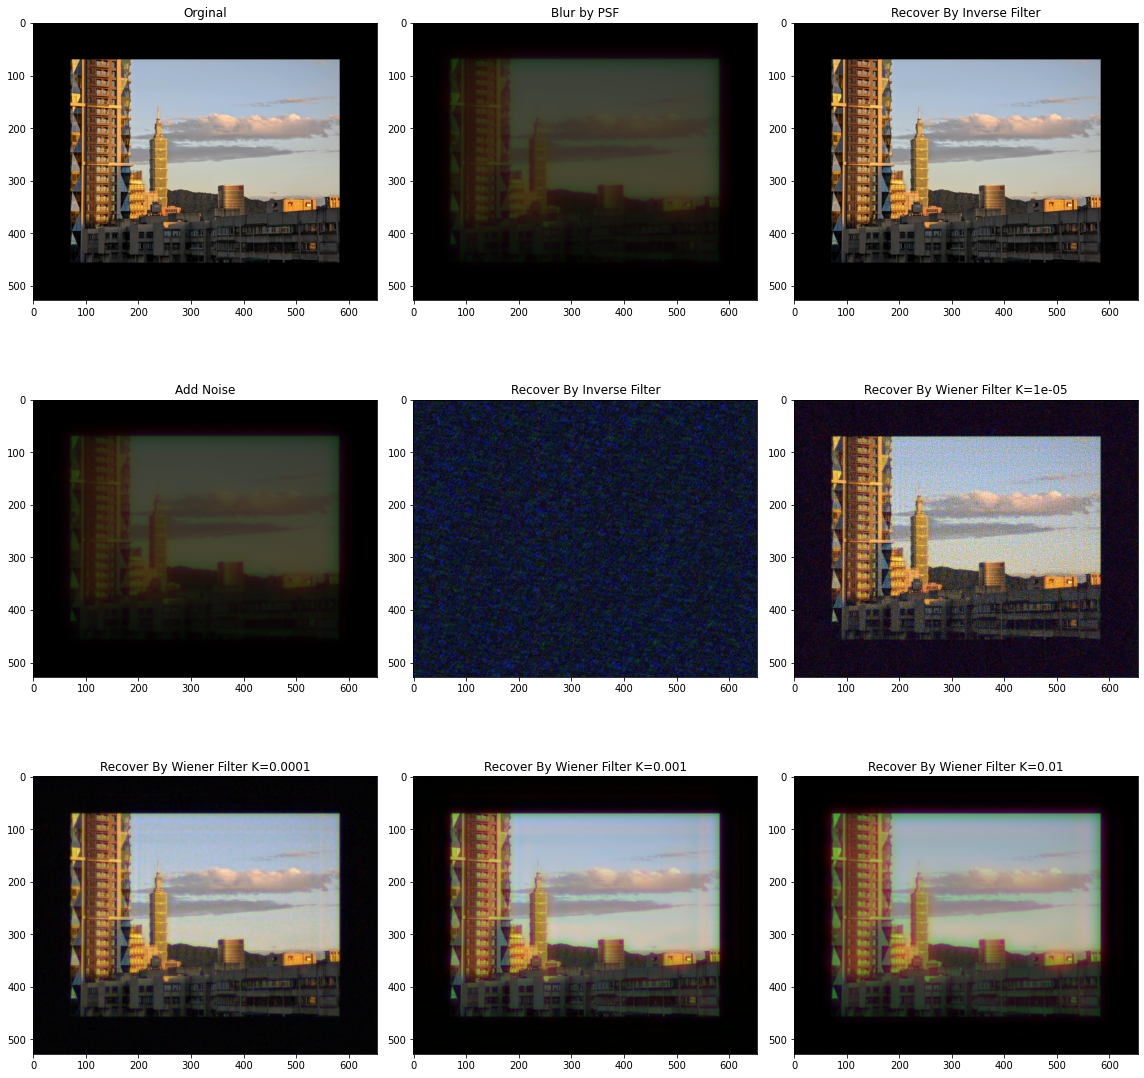

In [55]:
def evaluate(img, I_pad):
    X = tf.signal.fft2d(tf.transpose(tf.cast(img, tf.dtypes.complex64), [2, 0, 1]))
    H = tf.signal.fft2d(I_pad)
    Y = X*H

    blur_img = tf.abs(tf.signal.ifft2d(Y))

    Y_inv =Y/H
    invert_img = tf.abs(tf.signal.ifft2d(Y_inv))

    noise_img = blur_img + (tf.random.uniform(Y.shape)-0.5)*0.005

    Y2 = tf.signal.fft2d(tf.cast(noise_img, tf.dtypes.complex64))

    Y2_inv = Y2/H
    invert_noise_img = tf.abs(tf.signal.ifft2d(Y2_inv))

    plt.figure(figsize=(16,16))

    plt.subplot(3, 3, 1)
    plt.title("Orginal")
    plt.imshow(img)

    plt.subplot(3, 3, 2)
    plt.title("Blur by PSF")
    plt.imshow(tf.transpose(blur_img, [1, 2, 0]))

    plt.subplot(3, 3, 3)
    plt.title("Recover By Inverse Filter")
    plt.imshow(tf.transpose(invert_img, [1, 2, 0]))

    plt.subplot(3, 3, 4)
    plt.title("Add Noise")
    plt.imshow(tf.transpose(noise_img, [1, 2, 0]))

    plt.subplot(3, 3, 5)
    plt.title("Recover By Inverse Filter")
    plt.imshow(tf.transpose(invert_noise_img/np.max(invert_noise_img), [1, 2, 0]))


    wiener = None
    for i in range(4):
        K = [0.00001, 0.0001, 0.001, 0.01][i]
        W = tf.math.conj(H)/(tf.cast(tf.abs(H)**2+K, tf.dtypes.complex64))

        Y2_wiener = Y2*W
        wiener_noise_img = tf.abs(tf.signal.ifft2d(Y2_wiener))
        plt.subplot(3, 3, 6+i)
        plt.title(f"Recover By Wiener Filter K={K}")
        plt.imshow(tf.transpose(wiener_noise_img, [1, 2, 0]))

        if wiener == None:
            wiener = wiener_noise_img
    plt.tight_layout()

    return noise_img, wiener

noise_img, wiener = evaluate(img, I_pad)

In [56]:
img_out = tf.abs(tf.transpose(wiener, [1, 2, 0])).numpy()
img_out = (img_out/np.max(img_out)*256).astype("uint8")
Image.fromarray(img_out).save("./hans_result/noise_image_reconstructed.png")

In [52]:
# for i in range(20):
#     I = createPSF(i, lens_mask)
#     plt.clf()
#     plt.imshow(tf.transpose(tf.abs(I), [1, 2, 0])/tf.reduce_max(tf.abs(I)))
#     plt.savefig(f"./hans_result/focal_length_psf_{i}.jpg")
#     I_pad = padding(I, img)
#     plt.clf()
#     evaluate(img, I_pad)
#     plt.savefig(f"./hans_result/focal_length_{i}.jpg")


In [53]:
# for i in range(20):
#     I = createPSF(9, lens_mask, i*3/180*np.pi)
#     plt.clf()
#     plt.imshow(tf.transpose(tf.abs(I), [1, 2, 0])/tf.reduce_max(tf.abs(I)))
#     plt.savefig(f"./hans_result/angle_psf_{i}.jpg")
#     I_pad = padding(I, img)
#     plt.clf()
#     evaluate(img, I_pad)
#     plt.savefig(f"./hans_result/angle_psf_{i}.jpg")
